# **RECOMPRA EM E-COMMERCE: GRADIENT BOOSTING**



### Instalação de bibliotecas

In [ ]:
# Apenas a biblioteca shap precisa ser instalada; as demais utilizadas neste notebook já vêm pré-instaladas no Google Colab
! pip install shap

### Carregamento de bibliotecas

In [2]:
from IPython.display import display
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import ensemble                                   # Gradient boosting
from sklearn.model_selection import KFold, cross_validate      # Validação cruzada
from sklearn.model_selection import GridSearchCV               # Otimização de hiperparâmetros via grid search
from sklearn.model_selection import RandomizedSearchCV         # Otimização de hiperparâmetros via random search
import shap                                                    # Interpretabilidade de modelos de ML

### Leitura da base de dados

In [3]:
dados_ecommerce = pd.read_table("Recompra_eCommerce.txt", sep = "\t")

### Visualização da base de dados

In [4]:
display(dados_ecommerce)

,ID_CLIENTE,IDADE,VALOR_COMPRA_SITE,QTDE_ITENS_COMPRA_SITE,FLAG_ACESSORIOS_COMPRA_SITE,FLAG_FEMININA_COMPRA_SITE,FLAG_MASCULINA_COMPRA_SITE,NOTA_SATISF_COMPRA_SITE,FLAG_COMPROU_LOJA_FISICA_6M,QTDE_COMPRAS_LOJA_FISICA_6M,QTDE_ITENS_LOJA_FISICA_6M,FLAG_RECOMPRA_PROX_3_MESES
0,1,29,185.5,2,0,1,0,7,1,4,4,1
1,2,27,215.5,2,0,1,1,7,1,2,2,1
2,3,29,106.4,4,0,1,0,10,1,1,5,1
3,4,18,140.2,1,0,1,0,8,1,1,4,0
4,5,24,72.9,2,0,1,0,7,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1269,1270,40,165.9,6,0,1,0,8,1,3,9,1
1270,1271,33,55.6,1,0,1,0,9,0,0,0,0
1271,1272,28,105.7,4,0,0,1,6,0,0,0,0
1272,1273,28,284.9,3,0,1,1,8,0,0,0,0


### Separação de features e target

In [5]:
X = dados_ecommerce.drop(columns = ['FLAG_RECOMPRA_PROX_3_MESES', 'ID_CLIENTE'])
y = dados_ecommerce['FLAG_RECOMPRA_PROX_3_MESES']

### Criação de colunas dummy para variáveis explicativas qualitativas

In [6]:
# Não necessário para esta base de dados, pois todas as variáveis explicativas são quantitativas

### Modelo 1: gradient boosting com otimização de hiperparâmetros via validação cruzada, com grid search

In [7]:
# Grid de valores dos hiperparâmetros
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'max_depth': [2, 3, 5, 10],
    'min_samples_leaf': [10, 20, 50, 100]
}

In [8]:
# Busca da melhor combinação de hiperparâmetros, via validação cruzada com grid search, com otimização de AUC e k = 10 (EXECUÇÃO ONEROSA)
gradboost = ensemble.GradientBoostingClassifier(random_state = 123)
cv = KFold(n_splits = 10, shuffle = True, random_state = 123)
scoring = {'AUC': 'roc_auc', 'balanced_accuracy': 'balanced_accuracy', 'recall': 'recall'}
grid_search = GridSearchCV(gradboost, param_grid, cv = cv, scoring = scoring, refit = 'AUC')
grid_search.fit(X, y)

GridSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
             estimator=GradientBoostingClassifier(random_state=123),
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.5],
                         'max_depth': [2, 3, 5, 10],
                         'min_samples_leaf': [10, 20, 50, 100],
                         'n_estimators': [10, 50, 100, 200]},
             refit='AUC',
             scoring={'AUC': 'roc_auc',
                      'balanced_accuracy': 'balanced_accuracy',
                      'recall': 'recall'})

In [9]:
# Melhor configuração de hiperparâmetros identificada
print(grid_search.best_params_)

{'learning_rate': 0.1, 'max_depth': 2, 'min_samples_leaf': 50, 'n_estimators': 50}


In [10]:
# Tabela de desempenho com todas as combinações de hiperparâmetros testadas, ordenadas do maior para o menor AUC médio nos conjuntos de teste
resultados_grid = pd.DataFrame(grid_search.cv_results_)
resultados_grid = resultados_grid[['params',
                                   'mean_test_AUC', 'std_test_AUC', 'rank_test_AUC',
                                   'mean_test_balanced_accuracy', 'std_test_balanced_accuracy', 'rank_test_balanced_accuracy',
                                   'mean_test_recall', 'std_test_recall', 'rank_test_recall']].sort_values(by = 'rank_test_AUC')
resultados_grid

,params,mean_test_AUC,std_test_AUC,rank_test_AUC,mean_test_balanced_accuracy,std_test_balanced_accuracy,rank_test_balanced_accuracy,mean_test_recall,std_test_recall,rank_test_recall
137,"{'learning_rate': 0.1, 'max_depth': 2, 'min_sa...",0.905228,0.021346,1,0.831056,0.028308,18,0.875611,0.040598,70
74,"{'learning_rate': 0.05, 'max_depth': 2, 'min_s...",0.905025,0.021423,2,0.830778,0.028322,21,0.876918,0.042073,59
71,"{'learning_rate': 0.05, 'max_depth': 2, 'min_s...",0.904614,0.019140,3,0.828865,0.024995,40,0.865380,0.036922,113
134,"{'learning_rate': 0.1, 'max_depth': 2, 'min_sa...",0.904468,0.019572,4,0.828945,0.027527,38,0.866872,0.035891,107
75,"{'learning_rate': 0.05, 'max_depth': 2, 'min_s...",0.904291,0.020229,5,0.829775,0.029353,29,0.868381,0.038548,99
...,...,...,...,...,...,...,...,...,...,...
4,"{'learning_rate': 0.01, 'max_depth': 2, 'min_s...",0.852049,0.026817,251,0.766469,0.032829,241,0.949245,0.024901,1
0,"{'learning_rate': 0.01, 'max_depth': 2, 'min_s...",0.852049,0.026817,251,0.766469,0.032829,241,0.949245,0.024901,1
76,"{'learning_rate': 0.05, 'max_depth': 2, 'min_s...",0.851395,0.025981,254,0.765745,0.032024,248,0.946281,0.024162,8
13,"{'learning_rate': 0.01, 'max_depth': 2, 'min_s...",0.851083,0.026045,255,0.765745,0.032024,248,0.946281,0.024162,8


In [11]:
# Modelo final a partir da melhor combinação de hiperparâmetros
gradboost_1 = grid_search.best_estimator_

### Modelo 2: gradient boosting com otimização de hiperparâmetros via validação cruzada, com random search

In [12]:
# Grid de valores dos hiperparâmetros
param_grid = {
    'n_estimators': np.arange(10, 201, 10),
    'learning_rate': np.arange(0.01, 0.51, 0.01),
    'max_depth': np.arange(2, 11),
    'min_samples_leaf': np.arange(10, 101)
}

In [13]:
# Busca da melhor combinação de hiperparâmetros, via validação cruzada com random search, com otimização de AUC e k = 10
gradboost = ensemble.GradientBoostingClassifier(random_state = 123)
cv = KFold(n_splits = 10, shuffle = True, random_state = 123)
scoring = {'AUC': 'roc_auc', 'balanced_accuracy': 'balanced_accuracy', 'recall': 'recall'}
random_search = RandomizedSearchCV(gradboost, param_grid, cv = cv, scoring = scoring, refit = 'AUC', n_iter = 50, random_state = 123)
random_search.fit(X, y)

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
                   estimator=GradientBoostingClassifier(random_state=123),
                   n_iter=50,
                   param_distributions={'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.3...
        49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
        62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,
        75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,
        88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100]),
                                        'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190, 200])},
                   random_state=123, refit='AUC',
                   scoring={'AUC': 'roc_auc',
                            'balanced_accuracy': 'balanced_accuracy',
                            'recall': 'recall'})

In [14]:
# Melhor configuração de hiperparâmetros identificada
print(random_search.best_params_)

{'n_estimators': 40, 'min_samples_leaf': 83, 'max_depth': 2, 'learning_rate': 0.26}


In [15]:
# Tabela com todas as combinações de hiperparâmetros testadas, ordenadas do maior para o menor AUC médio nos conjuntos de teste
resultados_grid = pd.DataFrame(random_search.cv_results_)
resultados_grid = resultados_grid[['params',
                                   'mean_test_AUC', 'std_test_AUC', 'rank_test_AUC',
                                   'mean_test_balanced_accuracy', 'std_test_balanced_accuracy', 'rank_test_balanced_accuracy',
                                   'mean_test_recall', 'std_test_recall', 'rank_test_recall']].sort_values(by = 'rank_test_AUC')
resultados_grid

,params,mean_test_AUC,std_test_AUC,rank_test_AUC,mean_test_balanced_accuracy,std_test_balanced_accuracy,rank_test_balanced_accuracy,mean_test_recall,std_test_recall,rank_test_recall
20,"{'n_estimators': 40, 'min_samples_leaf': 83, '...",0.903449,0.021807,1,0.832284,0.026675,2,0.874908,0.033241,3
11,"{'n_estimators': 130, 'min_samples_leaf': 15, ...",0.903277,0.021541,2,0.829451,0.029699,3,0.874440,0.038348,4
41,"{'n_estimators': 50, 'min_samples_leaf': 83, '...",0.902648,0.023406,3,0.834467,0.030226,1,0.875668,0.042322,2
18,"{'n_estimators': 200, 'min_samples_leaf': 17, ...",0.902434,0.016572,4,0.824576,0.026326,8,0.848645,0.036547,12
30,"{'n_estimators': 70, 'min_samples_leaf': 86, '...",0.901876,0.022809,5,0.824359,0.028886,9,0.852034,0.043768,11
37,"{'n_estimators': 20, 'min_samples_leaf': 64, '...",0.901874,0.021907,6,0.819664,0.031656,23,0.848104,0.045699,14
24,"{'n_estimators': 10, 'min_samples_leaf': 34, '...",0.901110,0.022229,7,0.820962,0.026922,20,0.855271,0.034189,9
36,"{'n_estimators': 80, 'min_samples_leaf': 75, '...",0.900778,0.021624,8,0.822109,0.023178,17,0.858628,0.028108,8
29,"{'n_estimators': 200, 'min_samples_leaf': 14, ...",0.900528,0.016028,9,0.821846,0.028528,18,0.842036,0.045325,21
45,"{'n_estimators': 60, 'min_samples_leaf': 43, '...",0.900077,0.023593,10,0.828672,0.035937,4,0.873753,0.046726,5


In [16]:
# Modelo final a partir da melhor combinação de hiperparâmetros
gradboost_2 = random_search.best_estimator_

### Estimativa de desempenho do modelo 1 em dados totalmente apartados, via validação cruzada aninhada

In [17]:
# Grid de valores dos hiperparâmetros
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'max_depth': [2, 3, 5, 11],
    'min_samples_leaf': [10, 20, 50, 100]
}

In [18]:
# Validação cruzada aninhada com grid search e otimização de AUC, k1 = 3 e k2 = 5 (EXECUÇÃO ONEROSA)
gradboost = ensemble.GradientBoostingClassifier(random_state = 123)
inner_cv = KFold(n_splits = 3, shuffle = True, random_state = 123)
outer_cv = KFold(n_splits = 5, shuffle = True, random_state = 123)

scoring = {'AUC': 'roc_auc', 'balanced_accuracy': 'balanced_accuracy', 'recall': 'recall'}
grid_search = GridSearchCV(gradboost, param_grid, cv = inner_cv, scoring = scoring, refit = 'AUC')
nested_scores = cross_validate(grid_search, X = X, y = y, cv = outer_cv, scoring = scoring)

In [19]:
# AUC das melhores configurações de hiperparâmetros identificados da camada interna (maximizando AUC), nos k1 conjuntos de teste da camada externa
print(nested_scores['test_AUC'].round(3))
print("Média de AUC: " + str(round(np.mean(nested_scores['test_AUC']), 3)))
print("D.P. de AUC: " + str(round(np.std(nested_scores['test_AUC']), 3)))

[0.891 0.903 0.917 0.905 0.924]
Média de AUC: 0.908
D.P. de AUC: 0.011


In [20]:
# Acurácia balanceada das melhores configurações de hiperparâmetros identificados da camada interna (maximizando AUC), nos k1 conjuntos de teste da camada externa
print(nested_scores['test_balanced_accuracy'].round(3))
print("Média de Acurácia Balanceada: " + str(round(np.mean(nested_scores['test_balanced_accuracy']), 3)))
print("D.P. de Acurácia Balanceada: " + str(round(np.std(nested_scores['test_balanced_accuracy']), 3)))

[0.811 0.822 0.85  0.831 0.85 ]
Média de Acurácia Balanceada: 0.833
D.P. de Acurácia Balanceada: 0.015


In [21]:
# Sensibilidade das melhores configurações de hiperparâmetros identificados da camada interna (maximizando AUC), nos k1 conjuntos de teste da camada externa
print(nested_scores['test_recall'].round(3))
print("Média de Sensibilidade: " + str(round(np.mean(nested_scores['test_recall']), 3)))
print("D.P. de Sensibilidade: " + str(round(np.std(nested_scores['test_recall']), 3)))

[0.838 0.872 0.869 0.904 0.891]
Média de Sensibilidade: 0.875
D.P. de Sensibilidade: 0.022


### Estimativa de desempenho do modelo 2 em dados totalmente apartados, via validação cruzada aninhada

In [22]:
# Grid de valores dos hiperparâmetros
param_grid = {
    'n_estimators': np.arange(10, 201, 10),
    'learning_rate': np.arange(0.01, 0.51, 0.01),
    'max_depth': np.arange(2, 11),
    'min_samples_leaf': np.arange(10, 101)
}

In [23]:
# Validação cruzada aninhada com random search e otimização de AUC, k1 = 3 e k2 = 5
gradboost = ensemble.GradientBoostingClassifier(random_state = 123)
inner_cv = KFold(n_splits = 3, shuffle = True, random_state = 123)
outer_cv = KFold(n_splits = 5, shuffle = True, random_state = 123)

scoring = {'AUC': 'roc_auc', 'balanced_accuracy': 'balanced_accuracy', 'recall': 'recall'}
random_search = RandomizedSearchCV(gradboost, param_grid, cv = inner_cv, scoring = scoring, refit = 'AUC', n_iter = 50, random_state = 123)
nested_scores = cross_validate(random_search, X = X, y = y, cv = outer_cv, scoring = scoring)

In [24]:
# AUC das melhores configurações de hiperparâmetros identificados da camada interna (maximizando AUC), nos k1 conjuntos de teste da camada externa
print(nested_scores['test_AUC'].round(3))
print("Média de AUC: " + str(round(np.mean(nested_scores['test_AUC']), 3)))
print("D.P. de AUC: " + str(round(np.std(nested_scores['test_AUC']), 3)))

[0.89  0.893 0.918 0.901 0.922]
Média de AUC: 0.905
D.P. de AUC: 0.013


In [25]:
# Acurácia balanceada das melhores configurações de hiperparâmetros identificados da camada interna (maximizando AUC), nos k1 conjuntos de teste da camada externa
print(nested_scores['test_balanced_accuracy'].round(3))
print("Média de Acurácia Balanceada: " + str(round(np.mean(nested_scores['test_balanced_accuracy']), 3)))
print("D.P. de Acurácia Balanceada: " + str(round(np.std(nested_scores['test_balanced_accuracy']), 3)))

[0.815 0.796 0.839 0.827 0.85 ]
Média de Acurácia Balanceada: 0.825
D.P. de Acurácia Balanceada: 0.019


In [26]:
# Sensibilidade das melhores configurações de hiperparâmetros identificados da camada interna (maximizando AUC), nos k1 conjuntos de teste da camada externa
print(nested_scores['test_recall'].round(3))
print("Média de Sensibilidade: " + str(round(np.mean(nested_scores['test_recall']), 3)))
print("D.P. de Sensibilidade: " + str(round(np.std(nested_scores['test_recall']), 3)))

[0.846 0.83  0.847 0.904 0.891]
Média de Sensibilidade: 0.863
D.P. de Sensibilidade: 0.029


### Aplicação do modelo final de gradient boosting na base de dados



In [27]:
# Aplicação do modelo (cálculo das probabilidades preditas)
y_prob = gradboost_1.predict_proba(X)[:,1]

In [28]:
# Definição de ponto de corte
ponto_corte = y.astype(int).mean()

In [29]:
# Atribuição da categoria predita
dados_ecommerce['y_pred'] = (y_prob >= ponto_corte).astype(int)

### Importância das features do modelo final

In [30]:
# Cálculo de medida de importância de Gini
importancias = gradboost_1.feature_importances_
features = X.columns

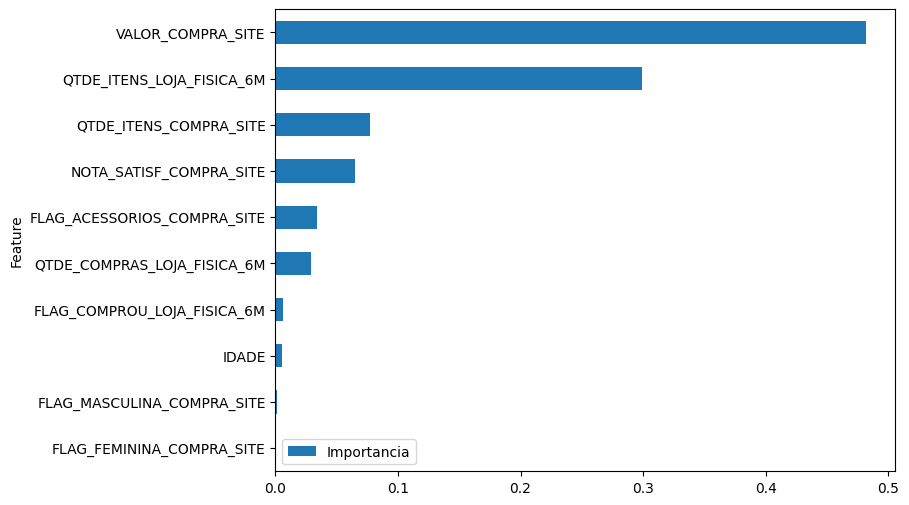

In [31]:
# Gráfico das importâncias de Gini
df_importancias = pd.DataFrame({'Feature': features, 'Importancia': importancias}).sort_values(by = 'Importancia', ascending = True)
df_importancias.plot.barh(x = 'Feature', y = 'Importancia', figsize = (8, 6))
plt.show()

In [32]:
# Cálculo de valores SHAP para as observações
explainer = shap.Explainer(gradboost_1)
valores_shap = explainer(X)

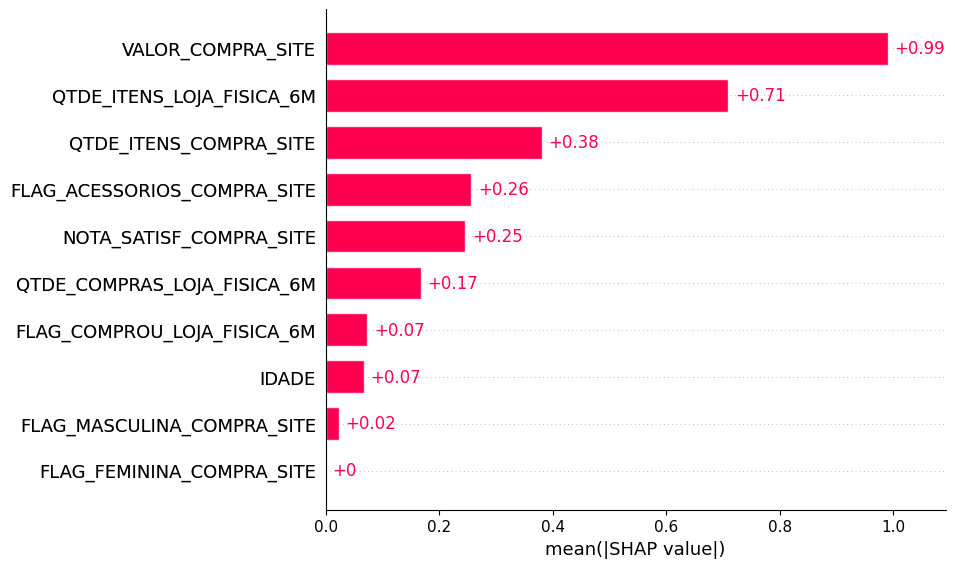

In [34]:
# Gráfico do SHAP absoluto médio por feature
shap.plots.bar(valores_shap)

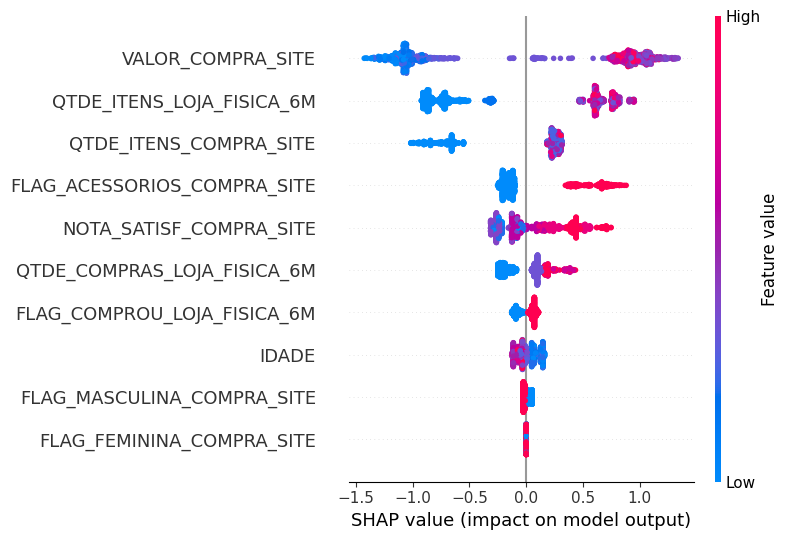

In [35]:
# Gráfico de distribuição de valores SHAP por feature: "enxame de abelhas" (beeswarm plot)
shap.summary_plot(valores_shap)